In [1]:
import pandas as pd
import numpy as np
import cudf
import datetime
import networkx as nx
import seaborn as sns

from igraph import *
from collections import Counter

# Creating unlabelled user interaction network

In [107]:
rio16 = pd.read_csv('Dataset/Network_DataFrame_V3.csv', 
                    index_col=0, lineterminator='\n',
                    dtype={'in_reply_to_user_id_str': str, 'in_reply_to_status_id_str': str, 
                           'in_reply_to_screen_name': str, 'id_str': str, 
                           'retweeted_status_id_str': str, 'quoted_status_id_str': str,
                           'user_id_str': str, 'user_screen_name': str, 
                           'retweeted_status_user_id_str': str, 'retweeted_status_user_screen_name': str, 
                           'quoted_status_user_id_str': str, 'quoted_status_user_screen_name': str})

In [5]:
labels = pd.read_csv('Dataset/rio16_Sports_relabelled_2.csv', 
                     index_col=0, lineterminator='\n')

In [109]:
rio16.drop(columns=['Label'], inplace = True)

In [110]:
rio16 = rio16.join(labels['New_Category'])

In [111]:
rio16

,is_quote_status,in_reply_to_user_id_str,in_reply_to_status_id_str,in_reply_to_screen_name,id_str,retweeted_status_id_str,quoted_status_id_str,created_at,place,user_followers_count,...,retweeted_status_user_statuses_count,retweeted_status_user_friends_count,quoted_status_created_at,quoted_status_user_followers_count,quoted_status_user_id_str,quoted_status_user_listed_count,quoted_status_user_screen_name,quoted_status_user_statuses_count,quoted_status_user_friends_count,New_Category
0,False,None,None,None,762040495128256514,NaN,NaN,2016-08-06,NaN,292,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
1,True,None,None,None,762040495627378688,NaN,762040150696292353,2016-08-06,NaN,209,...,NaN,NaN,2016/08/06,313.0,2209646390,5.0,bitacorarugby,553.0,758.0,-1
2,False,None,None,None,762040495698698241,762040125547175938,NaN,2016-08-06,NaN,2240,...,19722.0,2891.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
3,False,None,None,None,762040497808535552,761998284449845248,NaN,2016-08-06,NaN,39,...,2869.0,7251.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,False,None,None,None,762040497695318016,NaN,NaN,2016-08-06,NaN,7362,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14694485,False,None,None,None,768467674410156032,768358040315633664,NaN,2016-08-24,NaN,69,...,237.0,2283.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
14694486,True,None,None,None,768467678524796928,768365054114820096,768339673924177920,2016-08-24,NaN,1680,...,7203.0,4070.0,2016/08/24,1680.0,2953054786,108.0,FaydeEurope,6171.0,4518.0,-1
14694487,False,None,None,None,768467680231723008,768457589235576832,NaN,2016-08-24,NaN,17,...,1539.0,1022.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
14694488,False,None,None,None,768467685919248384,768453366405935105,NaN,2016-08-24,NaN,339,...,61890.0,298.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6


## Preparing dataframes for generating graphs

In [112]:
rio16_reply = rio16[['user_id_str', 'in_reply_to_user_id_str', 'created_at']][rio16['in_reply_to_user_id_str']!='None']

rio16_reply['type'] = ['reply' for i in range(len(rio16_reply))]

rio16_reply['weight'] = [1 for i in range(len(rio16_reply))] # Setting weights

rio16_reply

,user_id_str,in_reply_to_user_id_str,created_at,type,weight
56,2630754441,2630754441,2016-08-06,reply,1
111,3165545668,2235473955,2016-08-06,reply,1
172,2828788552,67334466,2016-08-06,reply,1
451,2542811191,872519802,2016-08-06,reply,1
554,2354415709,23738026,2016-08-06,reply,1
...,...,...,...,...,...
14694259,621173817,621173817,2016-08-24,reply,1
14694355,3501347181,35509768,2016-08-24,reply,1
14694373,174601765,403925836,2016-08-24,reply,1
14694466,255997474,93930924,2016-08-24,reply,1


In [113]:
rio16_retweet = rio16[['user_id_str', 'retweeted_status_user_id_str', 'created_at']]

rio16_retweet = rio16_retweet.dropna()

rio16_retweet['type'] = ['retweet' for i in range(len(rio16_retweet))]

rio16_retweet['weight'] = [1.5 for i in range(len(rio16_retweet))] # Setting weights

rio16_retweet

,user_id_str,retweeted_status_user_id_str,created_at,type,weight
2,286451294,14955353,2016-08-06,retweet,1.5
3,519988752,3243387724,2016-08-06,retweet,1.5
5,1259690419,28631611,2016-08-06,retweet,1.5
6,1092764504,412560019,2016-08-06,retweet,1.5
7,2715403297,1430054982,2016-08-06,retweet,1.5
...,...,...,...,...,...
14694485,1224226356,4153021756,2016-08-24,retweet,1.5
14694486,2953054786,281028483,2016-08-24,retweet,1.5
14694487,4403595814,187497062,2016-08-24,retweet,1.5
14694488,397517917,211276335,2016-08-24,retweet,1.5


In [114]:
rio16_quote = rio16[['user_id_str', 'quoted_status_user_id_str', 'created_at']]

rio16_quote = rio16_quote.dropna()

rio16_quote['type'] = ['quote' for i in range(len(rio16_quote))]

rio16_quote['weight'] = [3 for i in range(len(rio16_quote))] # Setting weights

rio16_quote

,user_id_str,quoted_status_user_id_str,created_at,type,weight
1,1339458218,2209646390,2016-08-06,quote,3
18,763367653,706181769997983745,2016-08-06,quote,3
25,733486876686946306,132353960,2016-08-06,quote,3
30,546044828,188986358,2016-08-06,quote,3
35,1611823945,4278089295,2016-08-06,quote,3
...,...,...,...,...,...
14694456,751340332823015424,711895597222072320,2016-08-24,quote,3
14694457,752858690248667136,559495360,2016-08-24,quote,3
14694474,2967853094,183123552,2016-08-24,quote,3
14694478,754429028812021760,17994536,2016-08-24,quote,3


In [122]:
rio16_reply = rio16_reply.rename(columns={"in_reply_to_user_id_str": 'target_id'})
rio16_retweet = rio16_retweet.rename(columns={"retweeted_status_user_id_str": 'target_id'})
rio16_quote = rio16_quote.rename(columns={"quoted_status_user_id_str": 'target_id'})

In [123]:
rio16_quote

,user_id_str,target_id,created_at,type,weight
1,1339458218,2209646390,2016-08-06,quote,3
18,763367653,706181769997983745,2016-08-06,quote,3
25,733486876686946306,132353960,2016-08-06,quote,3
30,546044828,188986358,2016-08-06,quote,3
35,1611823945,4278089295,2016-08-06,quote,3
...,...,...,...,...,...
14694456,751340332823015424,711895597222072320,2016-08-24,quote,3
14694457,752858690248667136,559495360,2016-08-24,quote,3
14694474,2967853094,183123552,2016-08-24,quote,3
14694478,754429028812021760,17994536,2016-08-24,quote,3


In [124]:
Network_df = pd.concat([rio16_reply,rio16_retweet,rio16_quote])

In [125]:
Network_df

,user_id_str,target_id,created_at,type,weight
56,2630754441,2630754441,2016-08-06,reply,1.0
111,3165545668,2235473955,2016-08-06,reply,1.0
172,2828788552,67334466,2016-08-06,reply,1.0
451,2542811191,872519802,2016-08-06,reply,1.0
554,2354415709,23738026,2016-08-06,reply,1.0
...,...,...,...,...,...
14694456,751340332823015424,711895597222072320,2016-08-24,quote,3.0
14694457,752858690248667136,559495360,2016-08-24,quote,3.0
14694474,2967853094,183123552,2016-08-24,quote,3.0
14694478,754429028812021760,17994536,2016-08-24,quote,3.0


## Generating network

In [126]:
User = Graph.DataFrame(Network_df, directed = True)

In [11]:
User = Graph.DataFrame(rio16_reply, directed = True)

G_tmp = Graph.DataFrame(rio16_retweet, directed = True)

G_tmp_q = Graph.DataFrame(rio16_quote, directed = True)

User = User.union([G_tmp, G_tmp_q]) # Combine the networks for different types of interaction.

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [127]:
User.ecount()

9715276

In [128]:
User.vcount()

2513767

In [14]:
'quote' in User.es['type_3']

True

## Putting all the type_x, weight_x attributes into type and weight attributes

In [15]:
for edge in User.es:
    if edge['type_1'] is not None:
        t = edge['type_1']
        w = edge['weight_1']
    elif edge['type_2'] is not None:
        t = edge['type_2']
        w = edge['weight_2']
    elif edge['type_3'] is not None:
        t = edge['type_3']
        w = edge['weight_3']
    edge['type'] = t
    edge['weight'] = w

In [16]:
del(User.es['type_1'])
del(User.es['type_2'])
del(User.es['type_3'])

del(User.es['weight_1'])
del(User.es['weight_2'])
del(User.es['weight_3'])

In [17]:
# Checking the existence of attributes and weights
for i in range(100):
    print(User.es(i)['type'],User.es(i)['weight'])

['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['reply'] [1]
['reply'] [1]
['reply'] [1]
['reply'] [1]
['quote'] [3]
['quote'] [3]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['quote'] [3]
['reply'] [1]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['retweet'] [1.5]
['quote'] [3]
['quote'] [3]
['quote'] [3]
['quote'] [3]
['quote'] [3]
['quote'] [3]
['quote'] [3]
['quote'] [3]
['quote'] [3]
['retw

In [69]:
User.write_graphml('Networks/User_Networks.graphml')# Save a check point

## Labelling Users

In [108]:
User = Graph.Read('Networks/User_Networks.graphml')

In [133]:
user_df = rio16[['user_id_str', 'user_screen_name', 
                 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 
                 'retweeted_status_user_id_str', 'retweeted_status_user_screen_name',
                 'quoted_status_user_id_str', 'quoted_status_user_screen_name', 'New_Category']]

### Labelling Sourse users

I label the users by the most common non -1 category of their tweets, when the user tweeted non -1 tweets.

In [134]:
cate_count = user_df[['New_Category', 'user_id_str']].groupby('user_id_str').value_counts(normalize=True)

In [135]:
# Easily turning a serie with multiindex to a dataframe.
cate_count.to_csv('Dataset/Category_count.csv')

cate_count = pd.read_csv('Dataset/Category_count.csv', 
                         lineterminator='\n', dtype={'user_id_str': str})

In [136]:
cate_count = cate_count.rename({'0': 'Relative_Frequency'}, axis = 1)
cate_count

,user_id_str,New_Category,Relative_Frequency
0,100000132,-1,1.00
1,1000003880,-1,1.00
2,1000005955,2,0.50
3,1000005955,-1,0.50
4,100000717,11,1.00
...,...,...,...
5419572,999998173,-1,0.50
5419573,999999750,-1,0.50
5419574,999999750,4,0.25
5419575,999999750,2,0.25


In [137]:
# Dropping the rows where Category is -1 and the relative frequency is not 1
cate_count.drop(cate_count.loc[((cate_count['Relative_Frequency'] != 1).astype(int)*(cate_count['New_Category'] == -1).astype(int)).astype(bool)].index, 
                inplace=True)

# Only keeps the rows with largest relative frequency for each user.
cate_count.drop_duplicates(subset=['user_id_str'], keep = 'first', inplace = True)
cate_count

,user_id_str,New_Category,Relative_Frequency
0,100000132,-1,1.00
1,1000003880,-1,1.00
2,1000005955,2,0.50
4,100000717,11,1.00
5,100000776,-1,1.00
...,...,...,...
5419569,99999593,12,0.50
5419570,999996920,4,1.00
5419571,999998173,0,0.50
5419574,999999750,4,0.25


In [138]:
# Setting a column for creating a graph with vertices attributes.
cate_count['target'] = cate_count['user_id_str']

cate_count

,user_id_str,New_Category,Relative_Frequency,target
0,100000132,-1,1.00,100000132
1,1000003880,-1,1.00,1000003880
2,1000005955,2,0.50,1000005955
4,100000717,11,1.00,100000717
5,100000776,-1,1.00,100000776
...,...,...,...,...
5419569,99999593,12,0.50,99999593
5419570,999996920,4,1.00,999996920
5419571,999998173,0,0.50,999998173
5419574,999999750,4,0.25,999999750


In [139]:
# Setting use id as index for easy indexing for the following step
cate_count.set_index('user_id_str',verify_integrity=True, inplace=True, drop = False)
cate_count

,user_id_str,New_Category,Relative_Frequency,target
user_id_str,,,,
100000132,100000132,-1,1.00,100000132
1000003880,1000003880,-1,1.00,1000003880
1000005955,1000005955,2,0.50,1000005955
100000717,100000717,11,1.00,100000717
100000776,100000776,-1,1.00,100000776
...,...,...,...,...
99999593,99999593,12,0.50,99999593
999996920,999996920,4,1.00,999996920
999998173,999998173,0,0.50,999998173


In [140]:
# Creating the edgeless network
G_no_edge = Graph.DataFrame(cate_count[['user_id_str', 'target']], directed = True, vertices=cate_count[['user_id_str', 'New_Category']])

G_no_edge.delete_edges()

G_no_edge.ecount()

0

In [141]:
G_no_edge.vs['New_Category']#Checking the existence of attribute

[-1,
 -1,
 2,
 11,
 -1,
 2,
 1,
 3,
 0,
 14,
 -1,
 1,
 1,
 -1,
 37,
 -1,
 1,
 0,
 -1,
 5,
 14,
 2,
 4,
 1,
 -1,
 8,
 7,
 6,
 -1,
 -1,
 -1,
 5,
 -1,
 -1,
 12,
 -1,
 41,
 -1,
 0,
 -1,
 -1,
 -1,
 3,
 -1,
 1,
 7,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 11,
 -1,
 -1,
 3,
 -1,
 -1,
 3,
 -1,
 0,
 -1,
 1,
 -1,
 4,
 -1,
 3,
 -1,
 -1,
 -1,
 4,
 13,
 -1,
 -1,
 14,
 -1,
 3,
 -1,
 -1,
 -1,
 -1,
 25,
 -1,
 13,
 3,
 -1,
 -1,
 0,
 -1,
 0,
 -1,
 1,
 13,
 0,
 14,
 30,
 4,
 -1,
 2,
 -1,
 0,
 -1,
 3,
 5,
 -1,
 3,
 -1,
 4,
 -1,
 1,
 26,
 -1,
 -1,
 0,
 0,
 1,
 12,
 -1,
 4,
 1,
 7,
 1,
 -1,
 -1,
 2,
 22,
 14,
 1,
 33,
 3,
 7,
 -1,
 -1,
 4,
 14,
 -1,
 0,
 -1,
 -1,
 21,
 0,
 -1,
 1,
 13,
 -1,
 16,
 12,
 37,
 -1,
 3,
 26,
 7,
 30,
 17,
 3,
 -1,
 -1,
 -1,
 -1,
 0,
 16,
 -1,
 -1,
 -1,
 4,
 4,
 0,
 -1,
 0,
 6,
 0,
 2,
 -1,
 -1,
 1,
 12,
 4,
 30,
 12,
 3,
 -1,
 13,
 -1,
 1,
 -1,
 8,
 -1,
 6,
 14,
 3,
 3,
 -1,
 23,
 5,
 -1,
 7,
 11,
 -1,
 -1,
 9,
 -1,
 1,
 17,
 -1,
 -1,
 -1,
 -1,
 -1,
 32,
 21,
 0,
 7,
 -1

In [142]:
User = User.union(G_no_edge)# Combine User network and G_no_edge network, and updating the attributes to the

In [143]:
User.vs['New_Category']# Checking the existence of vertex attribute in User network.

[-1,
 1,
 10,
 4,
 -1,
 8,
 -1,
 -1,
 -1,
 -1,
 None,
 -1,
 None,
 -1,
 8,
 -1,
 39,
 30,
 9,
 -1,
 24,
 2,
 -1,
 -1,
 4,
 -1,
 7,
 11,
 -1,
 -1,
 2,
 3,
 -1,
 -1,
 -1,
 -1,
 14,
 19,
 11,
 4,
 4,
 0,
 -1,
 4,
 -1,
 0,
 0,
 -1,
 9,
 0,
 -1,
 5,
 -1,
 -1,
 13,
 -1,
 -1,
 16,
 24,
 -1,
 -1,
 -1,
 4,
 0,
 -1,
 -1,
 5,
 19,
 -1,
 0,
 -1,
 -1,
 -1,
 -1,
 35,
 8,
 -1,
 -1,
 None,
 8,
 8,
 -1,
 7,
 -1,
 0,
 4,
 21,
 7,
 13,
 2,
 -1,
 8,
 -1,
 7,
 -1,
 -1,
 26,
 -1,
 -1,
 -1,
 3,
 -1,
 -1,
 -1,
 1,
 0,
 0,
 4,
 0,
 1,
 2,
 0,
 32,
 -1,
 4,
 5,
 17,
 -1,
 7,
 2,
 -1,
 0,
 34,
 1,
 -1,
 -1,
 1,
 3,
 -1,
 3,
 3,
 0,
 9,
 0,
 3,
 4,
 3,
 -1,
 -1,
 3,
 7,
 7,
 13,
 2,
 2,
 -1,
 0,
 4,
 2,
 -1,
 0,
 -1,
 0,
 4,
 4,
 -1,
 0,
 0,
 21,
 1,
 -1,
 -1,
 -1,
 33,
 -1,
 0,
 -1,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 4,
 -1,
 -1,
 -1,
 -1,
 4,
 7,
 23,
 -1,
 12,
 -1,
 7,
 -1,
 -1,
 1,
 -1,
 -1,
 4,
 4,
 4,
 -1,
 -1,
 None,
 -1,
 -1,
 0,
 18,
 21,
 -1,
 21,
 9,
 5,
 -1,
 -1,
 -1,
 -1,
 6,
 14,
 -1,
 38,
 1,
 3,
 -1,
 

In [144]:
User.ecount()

9715276

In [213]:
User.write_graphml('Networks/User_Networks_Labelled.graphml') # Check Point

In [2]:
User = Graph.Read('Networks/User_Networks_Labelled.graphml')

# Network Analysis

In [206]:
pip install python-louvain

Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 2.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9408 sha256=33a69b72d182c3f737f081a7b44161836a1d1d55a73861bb79dcc1279ddd5232
  Stored in directory: /root/.cache/pip/wheels/c4/74/92/d4aba2978040e7fd333ea34c24596d69044f129fc0f076348e
Successfully built python-louvain
Note: you may need to restart the kernel to use updated packages.


In [205]:
leng = len(User.vs.select(New_Category = 0))

In [170]:
leng

277617

In [145]:
User.is_directed()

True

In [159]:
User.vs[0].index

0

In [204]:
User.vs.select(New_Category = 0)

In [6]:
communities = np.unique(labels['New_Category'].to_numpy())[1:]

In [233]:
ordered_pairwise_interaction_intensity = np.zeros((len(communities),len(communities)))

In [38]:
st = datetime.datetime.now()
ordered_pairwise_interaction_intensity = np.zeros((len(communities),len(communities)))
leng = np.array([len(User.vs.select(New_Category = community)) for community in communities])
for community in communities:
    # leng = len(User.vs.select(New_Category = community))
    for i in User.vs.select(New_Category = community):
        for nbr in i.neighbors(mode = 'out'):
            if nbr['New_Category'] != -1:
                W_sum = np.sum(1/np.array(User.es.select(_source=i.index, _target=nbr.index)['weight']))
                ordered_pairwise_interaction_intensity[community][int(nbr['New_Category'])] += W_sum
    ordered_pairwise_interaction_intensity[community] = ordered_pairwise_interaction_intensity[community]/leng[community]
ed = datetime.datetime.now()
print("RUN TIME:", ed-st)    

RUN TIME: 0:15:40.334339


In [29]:
np.save('Networks/Interaction_Intensity_1.npy',ordered_pairwise_interaction_intensity)

In [50]:
row_sums = ordered_pairwise_interaction_intensity.sum(axis=1)
Norm_matrix = ordered_pairwise_interaction_intensity / row_sums[:, np.newaxis]

In [61]:
import matplotlib.pyplot as plt

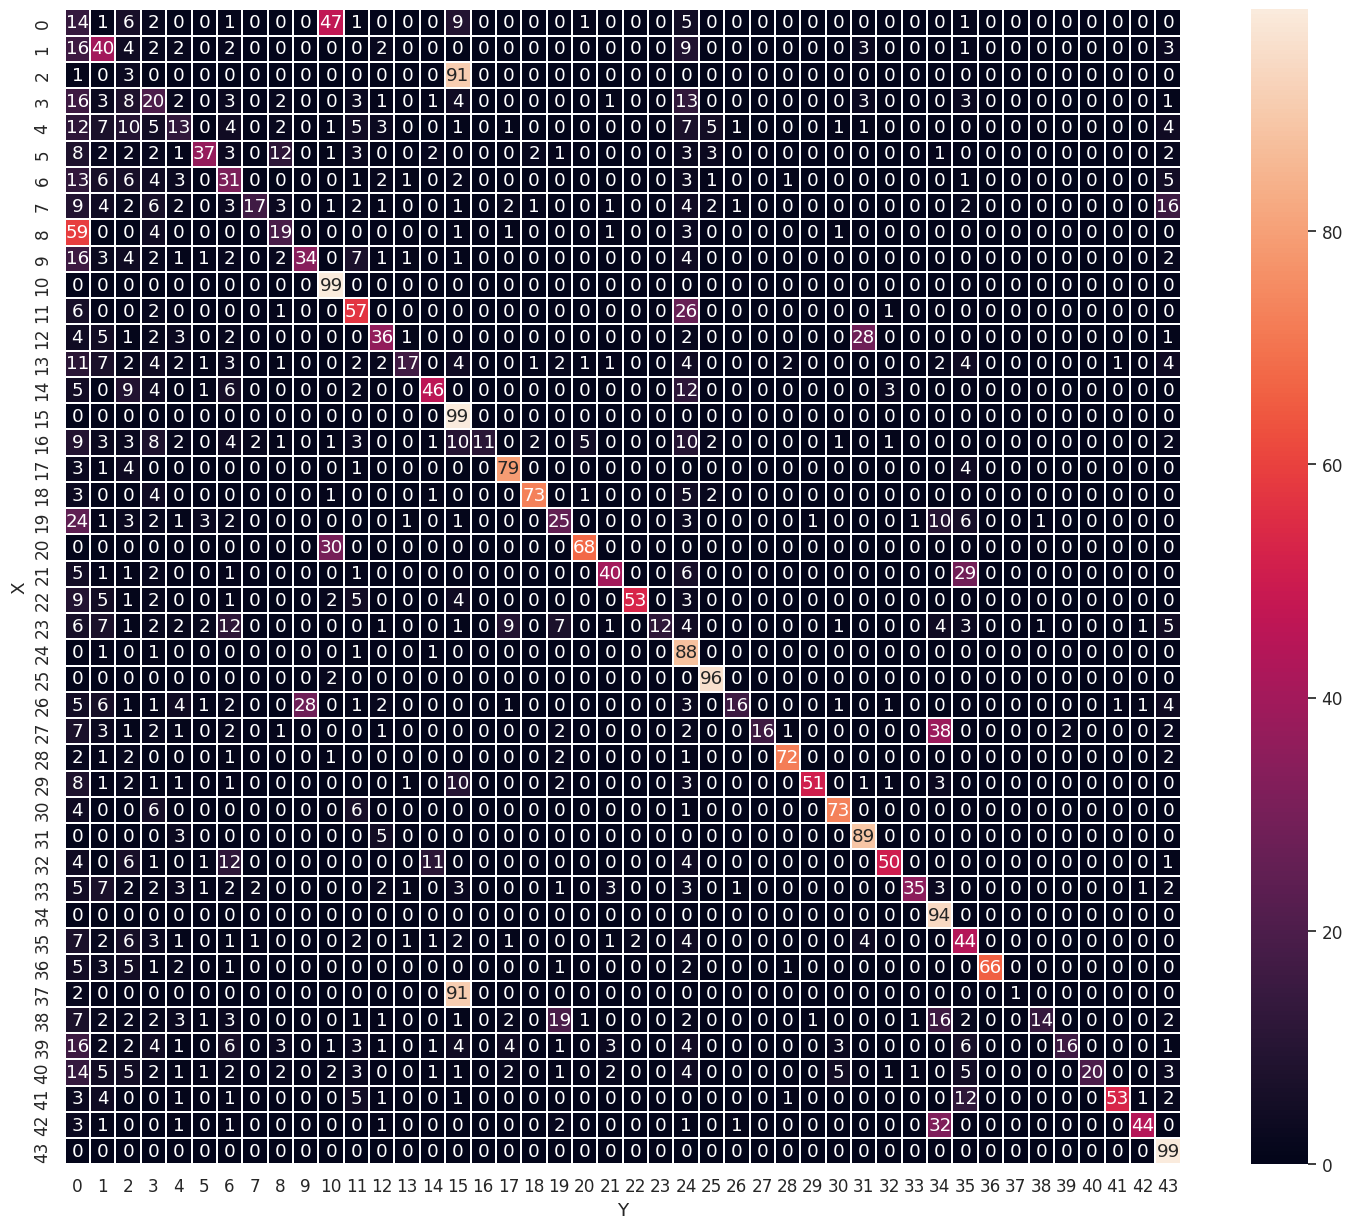

In [79]:
sns.set(rc={'figure.figsize':(18,15)})
sns.set(font_scale=1.1)
s = sns.heatmap((Norm_matrix*100).astype(int), annot = True, linecolor='white', linewidth=0.01)
s.set(xlabel='Y', ylabel='X')
plt.savefig("Images/IIS.png")

In [206]:
c = Counter()
p=0
for i in User.vs.select(New_Category = 0):
    for nbr in i.neighbors(mode = 'out'):
        if nbr['New_Category'] != -1:
            W_sum = np.sum(1/np.array(User.es.select(_source=i.index, _target=nbr.index)['weight']))
            c[nbr['New_Category']] += W_sum/leng

In [12]:
len(User.vs.select(New_Category = -1))

1283722

In [10]:
0 in User.vs['New_Category']

True

In [212]:
User.vs.select(New_Category = None)['New_Category'] = -1

In [193]:
w = 1
w *= 10
w

10

In [199]:
cc = Counter()

In [203]:
cc

Counter({1: 43.496713462224584,
         11: 0.5490812822730063,
         0: 17.40749545833057,
         4: 2.9286489816397983,
         2: 5.029022390491199,
         3: 3.201131335513672,
         6: 2.5969139716789518,
         12: 2.2740932642510994,
         9: 0.22843330175158583,
         8: 0.6482471615324746,
         5: 0.6493781377366797,
         24: 10.564504740771042,
         7: 0.35286182836555824,
         15: 0.6379044263257507,
         21: 0.21418352748826228,
         26: 0.697525773195825,
         None: 1.0868821965676947,
         34: 0.682275760660588,
         13: 0.3631584268526683,
         19: 0.41989451200900285,
         36: 0.15513784461152916,
         22: 0.3843731184289987,
         33: 0.2895563059060501,
         42: 0.6008105369807444,
         23: 0.10829493087557514,
         16: 0.19447869365170795,
         41: 0.3034439962767596,
         28: 0.3551813078440277,
         30: 0.83604724108773,
         40: 0.07218167072181635,
         14: 0.28

In [208]:
for i in c.keys():
    cc[i] = c[i]*leng/len(User.vs.select(New_Category = i))

In [201]:
cc.most_common(10)

[(1, 43.496713462224584),
 (0, 17.40749545833057),
 (24, 10.564504740771042),
 (2, 5.029022390491199),
 (31, 4.176767676767624),
 (43, 3.3772893772893706),
 (3, 3.201131335513672),
 (4, 2.9286489816397983),
 (6, 2.5969139716789518),
 (12, 2.2740932642510994)]

In [80]:
1295304/2

647652.0

In [214]:
import community.community_louvain as community_louvain
import matplotlib.cm as cm

In [125]:
import matplotlib.pyplot as plt
import pylab

In [137]:
xs, ys = zip(*[(left, count) for left, _, count in User.degree_distribution().bins()])

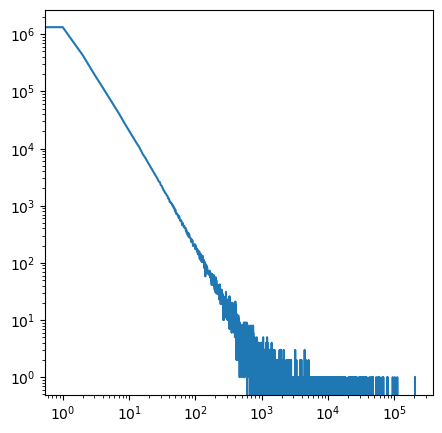

In [136]:
plt.figure(figsize=(5,5))
plt.plot(xs, ys)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [193]:
User_nx = User.to_networkx()

In [212]:
communities = community_louvain.best_partition(User_nx, random_state=123, weight = 'weight')

In [ ]:
communities.keys()

# Visualization

Visualization is done using Gephi, therfore no codes available